In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import os
import sys
sys.path.append('/home/cizinsky/garment-texture-completion')
CKPT_ROOT = '/scratch/izar/cizinsky/garment-completion/checkpoints'

from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
import pytorch_lightning as pl

import torch
from torchvision.transforms.functional import pil_to_tensor
from torchvision.utils import make_grid

from helpers.pl_module import GarmentInpainterModule
from helpers.dataset import get_dataloaders
from helpers.data_utils import denormalise_image_torch
from helpers.data_utils import torch_image_to_pil, denormalise_image_torch

In [ ]:
pl.seed_everything(42);

Seed set to 42


### Inspection of trained models

---


In [ ]:
!ls /scratch/izar/cizinsky/garment-completion/checkpoints/

bright-universe-112  fast-universe-159	    rose-sun-129
cerulean-smoke-152   fearless-jazz-157	    sandy-capybara-119
cerulean-star-109    fluent-aardvark-116    soft-dust-146
cosmic-cosmos-123    glamorous-thunder-121  stellar-feather-136
crisp-cosmos-153     glorious-oath-130	    stellar-pond-132
curious-oath-144     glowing-disco-164	    swift-lake-110
devout-wind-122      graceful-cloud-156     twilight-sponge-160
eager-energy-111     grateful-terrain-163   unique-water-133
exalted-forest-117   honest-bird-113	    valiant-resonance-120
faithful-dew-158     lilac-hill-102	    vivid-smoke-128
fallen-dew-140	     morning-microwave-118  worthy-paper-139
fallen-shape-155     peach-firebrand-106


In [ ]:
run_name = "fast-universe-159"
checkpoint_path = f"{CKPT_ROOT}/{run_name}/last.ckpt"
os.path.exists(checkpoint_path)

True

In [6]:
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
cfg = checkpoint["hyper_parameters"]
cfg.data.num_workers = 10
trn_dataloader, val_dataloader = get_dataloaders(cfg)

In [13]:
model = GarmentInpainterModule(cfg, trn_dataloader)
model.setup()
model.load_state_dict(checkpoint["state_dict"])
model.eval().cuda()
print("✅ Model loaded!")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Model loaded!


In [8]:
batch = next(iter(val_dataloader))

In [ ]:
n = 5

In [36]:
# reconstructed_imgs = model.inference(batch["partial_diffuse_img"][:n].to("cuda"), num_inference_steps=50, guidance_scale=7.5, image_guidance_scale=1.5)
partial_img = batch["partial_diffuse_img"][2].unsqueeze(0).to("cuda")
image_guidance_scale = [2.5, 5.0, 7.5, 10.0]
text_guidance_scale = [2.5, 5.0, 7.5, 10.0]
results = []
for img_scale in image_guidance_scale:
    row_results = []
    for t_scale in text_guidance_scale:
        reconstructed_imgs = model.inference(partial_img, num_inference_steps=50, guidance_scale=t_scale, image_guidance_scale=img_scale)
        row_results.extend(reconstructed_imgs)
    results.append(row_results)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

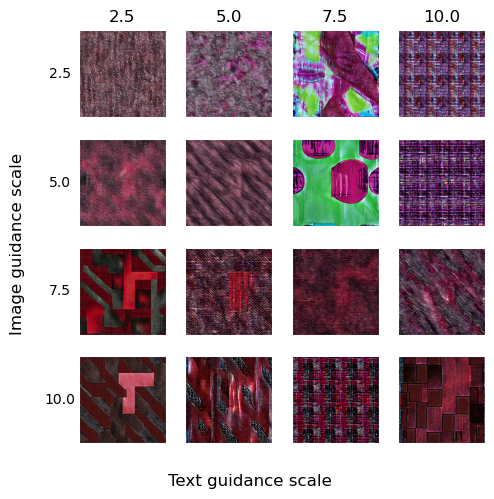

In [56]:
fig, axs = plt.subplots(
    len(image_guidance_scale),
    len(text_guidance_scale),
    figsize=(5, 5),
    tight_layout=True
)

for i, img_scale in enumerate(image_guidance_scale):
    for j, t_scale in enumerate(text_guidance_scale):
        ax = axs[i, j]
        ax.imshow(results[i][j])
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor('white')

        # keep your per-row / per-col numeric labels if you want
        if j == 0:
            ax.set_ylabel(f"{img_scale}", rotation=0, labelpad=10, va='center')
        if i == 0:
            ax.set_title(f"{t_scale}")

# now add the “global” labels
fig.supxlabel("Text guidance scale", fontsize=12)
fig.supylabel("Image guidance scale", fontsize=12)

plt.show()

In [20]:
cond_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["partial_diffuse_img"][:n])]
target_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["full_diffuse_img"][:n])]

In [35]:
def plot_images(index):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(cond_images[2])
    axs[0].set_title("Condition")
    axs[0].axis("off")
    axs[1].imshow(results[index])
    img_guidance = image_guidance_scale[index]
    axs[1].set_title(f"Predicted, IMG_GUIDE={img_guidance}")
    axs[1].axis("off")
    axs[2].imshow(target_images[2])
    axs[2].set_title("Target")
    axs[2].axis("off")
    plt.show()

interact(plot_images, index=IntSlider(min=0, max=len(results)-1, step=1));

interactive(children=(IntSlider(value=0, description='index', max=4), Output()), _dom_classes=('widget-interac…